In [36]:
using CairoMakie
using LinearAlgebra
using PyPlot
μ= 0.1
n= 20
ρ=1.0
L = 10.0
ν= μ/ρ
h = L/n
dt = 0.05
v_top = 10.0
function grad(ϕ,h)
    ∇ϕ= zeros(2,n,n)
    for i in 2:n-1
        for j in 2:n-1
            ∇ϕ[1,i,j]= (ϕ[i+1,j]-ϕ[i-1,j])/(2h)
            ∇ϕ[2,i,j]= (ϕ[i,j+1]-ϕ[i,j-1])/(2h)
        end
    end
    return ∇ϕ
end

function div(∇ϕ,h)
    divϕ= zeros(n,n)
    for i in 2:n-1
        for j in 2:n-1
            divϕ[i,j]= (∇ϕ[1,i+1,j]-∇ϕ[1,i-1,j]+∇ϕ[2,i,j+1]-∇ϕ[2,i,j-1])/(2h)
        end
    end
    return divϕ
end

#(u\cdot \nabla)u
function conv(u,h)
    conv= zeros(2,n,n)
    for i in 2:n-1
        for j in 2:n-1
            conv[1,i,j]= u[1,i,j]*(u[1,i+1,j]-u[1,i-1,j])/(2h)+u[2,i,j]*(u[1,i,j+1]-u[1,i,j-1])/(2h)
            conv[2,i,j]= u[1,i,j]*(u[2,i+1,j]-u[2,i-1,j])/(2h)+u[2,i,j]*(u[2,i,j+1]-u[2,i,j-1])/(2h)
        end
    end
    return conv
end

function curl(∇ϕ,h)
    curlϕ= zeros(n,n)
    for i in 2:n-1
        for j in 2:n-1
            curlϕ[i,j]=-((∇ϕ[1,i,j+1]-∇ϕ[1,i,j-1])/(2h)- (∇ϕ[2,i+1,j]-∇ϕ[2,i-1,j])/(2h))
        end
    end
    return curlϕ
end
function Laplacian(ϕ,h)
    Δϕ= zeros(2,n,n)
    for i= 2:n-1
        for j = 2:n-1
            Δϕ[1,i,j] = (ϕ[1,i+1,j]+ϕ[1,i-1,j]+ϕ[1,i,j+1]+ϕ[1,i,j-1]-4*ϕ[1,i,j])/h^2
            Δϕ[2,i,j] = (ϕ[2,i+1,j]+ϕ[2,i-1,j]+ϕ[2,i,j+1]+ϕ[2,i,j-1]-4*ϕ[2,i,j])/h^2
        end
    end
    return Δϕ
end
    
function evolveu(u,p,dt,h)
    v= copy(u)
    for i in 2:n-1
        for j in 2:n-1
            v[1,i,j]= u[1,i,j]+dt*(ν*Laplacian(u,h)[1,i,j]-grad(p,h)[1,i,j]-conv(u,h)[1,i,j])
            v[2,i,j]= u[2,i,j]+dt*(ν*Laplacian(u,h)[2,i,j]-grad(p,h)[2,i,j]-conv(u,h)[2,i,j])
        end
        
    end
    #velocity bc: Dirichlet BC on top and bottom, Neumann BC on sides
    v[1,1,:].= v[1,2,:]
    v[1,n,:].= v[1,n-1,:]
    v[1,:,1].= 0
    v[1,:,n].= 0
    v[2,1,:].= 0
    v[2,n,:].= 0
    v[2,:,1].= 0
    v[2,:,n].= 0
    #top boundary condition
    return v
end

function PoissonSOR(p,rho,h)
    pold = copy(p)
    ω= 1.9
    for i in 2:n-1
        for j in 2:n-1
            p[i,j]= (1-ω)*p[i,j]+ω*(p[i+1,j]+p[i-1,j]+p[i,j+1]+p[i,j-1]-h^2*rho[i,j])/4
        end
    end
    #bcs 
    p[1,:].= p[2,:]
    p[n,:].= p[n-1,:]
    p[:,1].= p[:,2]
    p[:,n].= 0
    error= norm(p-pold)
    return p,error
end

function evolvep(u,p,h) #evolve p with Successive over-relaxation ( ∇²p = ∇⋅(-∇\cdot(u\cdot \nabla)u+ν∇²(u)))
    i=0
    error =10
   while error>1e-6&&i<50
        p,error= PoissonSOR(p,div(conv(u,h)-ν*grad(div(u,h),h),h),h)
        i+=1
    end
    return p
end

function incompress(u,p,h) #make the fluid flow incompressible
    u[1,:,:] -= grad(p,h)[1,:,:]
    u[2,:,:] -= grad(p,h)[2,:,:]
    return u
end

incompress (generic function with 1 method)

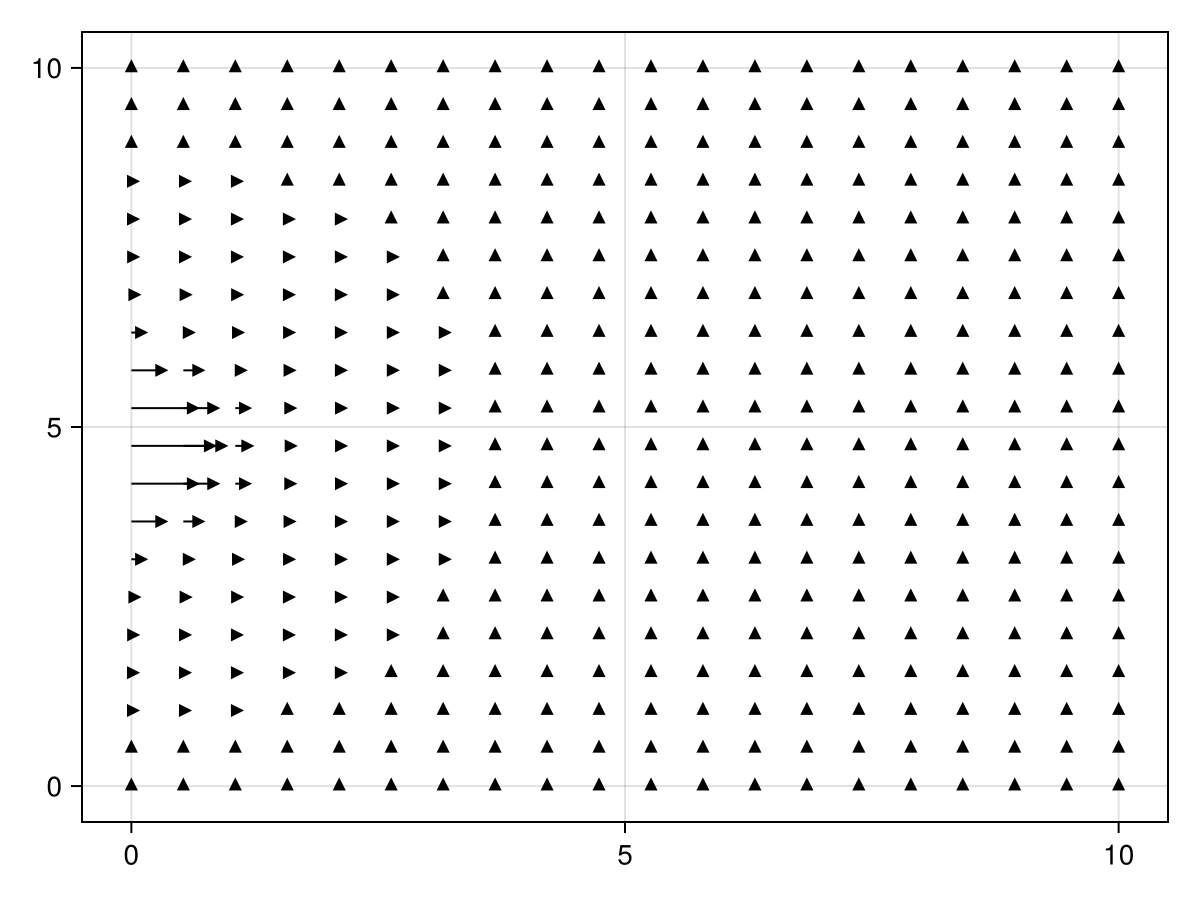

CairoMakie.Screen{IMAGE}


In [37]:
u=zeros(2,n,n) 
p=zeros(n,n)
# initial stream
for i in 1:n
    for j in 1:n
        u[1,i,j]= v_top*exp(-(0.5*i)^2-(0.5*(j-n÷2))^2)
    end
end

# Plot the vector field
scene = arrows(x,y, u[1,:,:], u[2,:,:])
display(scene)

In [38]:
#Evolve the system
numsteps = 100
for i in 1:numsteps
    #PyPlot.close("all")
    #PyPlot.contourf(X,Y, p)
    #PyPlot.streamplot(Xbar,Ybar, u[1,:,:], u[2,:,:],color="black")
    #savefig("NavierStokes$i.png")
    if i%1==0
        println(i)
        scene = heatmap(x,y,p)
        xlims!( 0, L)
        ylims!( 0, L)
        arrows!(x,y, u[1,:,:], u[2,:,:],arrowsize=5,lengthscale=0.3)
        save("NavierStokes$i.png", scene)
    end
    u= evolveu(u,zeros(n,n),dt/2,h)
    p= evolvep(u,p,h)
    u= evolveu(u,p,dt/2,h)
end


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


UndefVarError: UndefVarError: `strength` not defined

In [25]:
u[2,:,:]


20×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  